# Prerequisites
All computational and statistics packages have been tested in Anaconda environment (python 3.6)
1. Install Anaconda
https://www.anaconda.com/download/#linux
2. Install Spark and Java 8
https://medium.com/@GalarnykMichael/install-spark-on-ubuntu-pyspark-231c45677de0  

***Install "pyspark"***

In [2]:
try:
    print('Trying to import pyspark...')
    import pyspark
except ImportError:
    print('Pyspark import failed...')
    print('Installing pyspark in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} pyspark

Trying to import pyspark...


***Create Spark Context***
If you enqounter any error, try to reconfigure Spark on your machine (link in the first cell - .bashrc file configuration).

In [3]:
from pyspark import SparkConf, SparkContext
try:
    sc
except NameError:
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)
else:
    if sc != None:
        sc.stop()
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)

Create SQL context for spark computation.

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
import scipy.stats as sts

from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib
import logging, sys

In [5]:
try:
    print('Trying to import paramiko...')
    import paramiko
    print('Paramiko imported.')
except ImportError:
    print('Paramiko import failed...')
    print('Installing paramiko in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} paramiko

Trying to import paramiko...
Paramiko imported.


Paramiko installation

SCP installation

In [6]:
try:
    print('Trying to import scp...')
    import scp
    print('Scp imported.')
except ImportError:
    print('Scp import failed...')
    print('Installing scp in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} scp

Trying to import scp...
Scp imported.


Keras installation

In [7]:
try:
    print('Trying to import keras...')
    import keras
    print('Keras imported.')
except ImportError:
    print('Keras import failed...')
    print('Installing keras in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} keras

Trying to import keras...


Using TensorFlow backend.


Keras imported.


In [8]:
# keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [9]:
def loginanddownload(hostname,uname,pwd,sfile,tfile):
    """
    Can copy files and directories from PNDa to remote system.
    Usage example:
        loginanddownload(red_pnda_ip, username, password, remote_folder, local_destination)
        loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
    
    I am using it only for download full copy of /data folder from pnda VM. There is a dependency of openssh-server
    installation on red_pnda VM.
    
    """
    try:
        print("Establishing ssh connection")
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=hostname, username=uname, password=pwd)
    except paramiko.AuthenticationException:
        print("Authentication failed, please verify your credentials: %s")
    except paramiko.SSHException as sshException:
        print("Unable to establish SSH connection: %s" % sshException)
    except paramiko.BadHostKeyException as badHostKeyException:
        print("Unable to verify server's host key: %s" % badHostKeyException)
    except Exception as e:
        print(e.args)
    try:
        print("Getting SCP Client")
        scpclient = scp.SCPClient(ssh_client.get_transport())
        print("Hostname: %s", hostname)
        print("source file: %s", sfile)
        print("target file: %s", tfile)
        scpclient.get(sfile,tfile, recursive = True)
    except scp.SCPException as e:
        print("Operation error: %s", e) 

In [12]:
class Prediction:
    """
    Prediction class - class for preprocessing data from red_pnda.
    Not full variables are in use (this is a changed copy of Lecturer shared file)
    
    Prediction class takes exacly one argument - bytes (network traffic data)
    It is further processed and returned in other format.
    
    """
    def __init__(self, bytes):
        self.bytes = bytes
        self.omega = 2.0 * np.pi / len(bytes)
        self.export = pd.DataFrame()
        self.x = None
        self.data = None
        self.y = None
        self.train = None
        self.index = None
        self.train_mean = None
        self.train_std = None

    def prepare_data_for_prediction(self):
        """
        From RAW data compute time dependency (x) and bandwidth (y).
        """
        self.train = self.bytes
        self.train_mean = np.mean(self.train)
        self.train_std = np.std(self.train)
        self.train = (self.train - self.train_mean) / self.train_std
        self.index = np.asarray(range(len(self.train)), dtype=np.float64)
        self.x = np.asarray(range(len(self.train)), dtype=np.float64)
        self.y = self.train
        self.data = pd.DataFrame(np.column_stack([self.x, self.y]), columns=['x', 'y'])

    def proceed_prediction(self, percent):
        """
        Start data preprocessing.
        """
        self.prepare_data_for_prediction()

In [17]:
class WatchDog:
    """
    WatchDog class - extracts bandwidth information from collected flow and port data.
    (Not all variables are in use)
    
    self.dpid - particular switch identification number
    self.port_no - particular port number on the switch
    """
    def __init__(self, data_path):    
        self.interval = 300
        self.unusual = 0
        self.normal_work = True
        self.train_data = None
        self.pred = None
        self.pi = None
        self.current_stats = None
        self.sched = BackgroundScheduler()
        self.sched.start()
        self.dpid = 2
        self.port_no = 2
        self.resampled = None
        self.data_path = data_path
        
    def get_last_hour_stats(self):
        """
        Currently not in use.
        """
        last_hour_time = datetime.now() - timedelta(hours = 1)
        year = int(last_hour_time.strftime("%Y"))
        month = int(last_hour_time.strftime("%m"))
        day = int(last_hour_time.strftime("%d"))
        hour = int(last_hour_time.strftime("%H"))
        self.train_data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
        
    def get_previous_day_stats(self):
        """
        Gather statistics from particular hour/day.
        You can change dates based on your gathered data.
        """
        year="2018"
        month="12"
        day="22"
        hour=12
        data = sqlContext.read.json(self.data_path+"data/year="+year+"/month="+month+"/day="+day+"/hour="+str(hour)+"/dump.json")

        d = []
#         for h in range(hour+1,24):
        # merge stats starts from specific hour till other specific hour (hour+1,hour_number)
        for h in range(hour+1,15):
            d.append(sqlContext.read.json(self.data_path+"data/year="+year+"/month="+month+"/day="+day+"/hour="+str(h)+"/dump.json"))
        for i in range(0,len(d)):
            data = data.unionAll(d[i])            
        self.train_data = data

    
    def get_current_stats(self):
        """
        Currently not in use.
        """
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d"))
        hour = int(time.strftime("%H"))
        self.current_stats = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
    
    def get_port_stats(self,data,dpid,port_no):
        """
        Gathers data from specific port on the switch.
        """
        port = data.filter((data['origin']=='port_stats') & 
                           (data['switch_id']==dpid) & 
                           (data['port_no']==port_no)).orderBy('timestamp')
        port = port.toPandas()
        ts = pd.Series(port['timestamp'].astype(int))
        ts = pd.to_datetime(ts, unit='s')
        index = pd.DatetimeIndex(ts)
        raw_data = pd.Series(port['tx_bytes'].values, index=index)
        return raw_data, port
    
    def get_last_tput(self,dpid,port_no):
        """
        Currently not in use.
        """
        last_two_rows = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                           (self.current_stats['switch_id']==dpid) & 
                           (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(2)
        last_two_rows = last_two_rows.toPandas()
        bytes = last_two_rows['tx_bytes'].astype(int)
        time = last_two_rows['timestamp'].astype(int)
        tput = (bytes[0]-bytes[1])/(time[0]-time[1])
        return tput
        
    def resample_port_stats (self,raw_data, port):
        """
        Resamples data into correct date format and frequency.
        """
        raw_data = raw_data[~raw_data.index.duplicated(keep='first')]
        resampled_data = raw_data.resample('s').interpolate()
        resampled_data = [(y - x) for x,y in zip(resampled_data.values,resampled_data.values[1:])]
        ts_resampled = pd.Series(range(len(resampled_data)))
        ts_resampled= pd.to_datetime(ts_resampled, unit='s')
        return resampled_data, ts_resampled
               
    def proceed_prediction(self,enable_plot=False):
        """
        Start preprocessing traffic data.
        
        If you want to download data to your localhost just uncomment first line.
        This is not necessary when you have all the data stored locally already.
        """
#         loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
#         self.get_current_stats()
        self.get_previous_day_stats()
        data, port_stats = self.get_port_stats(self.train_data,self.dpid,self.port_no)
        resampled_data, ts_resampled = self.resample_port_stats(data, port_stats)
        self.resampled = resampled_data
        prediction = Prediction(resampled_data)
        prediction.proceed_prediction(95)
#         pred, pi, mean, median, peak, percentile, harm_num = prediction.proceed_prediction(95)
#         self.pred = pred
#         self.pi = pi
        self.ts_resampled = ts_resampled
        if enable_plot:
            fig = plt.figure(figsize=(15,8))
            ax = fig.add_subplot(111)
            ax.plot(ts_resampled,[x*8/1e6 for x in resampled_data])
#             ax.plot(ts_resampled,[x*8/1e6 for x in pred])
#             ax.plot(ts_resampled,[x*8/1e6 for x in (pred-pi)])
#             ax.plot(ts_resampled,[x*8/1e6 for x in (pred+pi)])
            ax.set_ylabel("Tput [Mbps]")
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             print("number of harmonics = %i" % harm_num)
#         return pred, pi

***Load the data***
Preprocessed data will be stored in wd.resampled

In [18]:
# please specify path to data folder
wd = WatchDog("/home/misliwin/Desktop/sdn/SDN_data_preprocessing_simple_NN_with_data/")
wd.proceed_prediction()
#wd.get_last_hour_stats()
series = [x*8/1e6 for x in wd.resampled]

# Simple Neural Network part (only one step ahead prediction)

In [19]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# load dataset
series = [x*8/1e6 for x in wd.resampled]

# transform data to be stationary
diff_values = difference(series, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-2000], supervised_values[-2000:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
range_size = 450

X_train = train_scaled[:,0]
Y_train = train_scaled[:,-1]
X_test = test_scaled[:,0]
Y_test = test_scaled[:,-1]


try:
    del X_train_complete
    del X_test_complete
    del Y_train_complete
    del Y_test_complete
    
except:
    pass

for i in range(range_size):
    if i == 0:
        X_train_complete  =  np.array(X_train[range_size:-1-range_size])
        X_test_complete  =  np.array(X_test[range_size:-1-range_size])
        
        Y_train_complete =  np.array(Y_train[2*range_size+1:])
        Y_test_complete  =  np.array(Y_test[2*range_size+1:])
        
    elif i ==1:
        X_train_complete = np.array([X_train_complete[:], X_train[range_size-i:-i-1-range_size]])
        X_test_complete = np.array([X_test_complete[:], X_test[range_size-i:-i-1-range_size]])
        
        Y_train_complete = np.array([Y_train_complete[:], Y_train[2*range_size-i:-i-1]])
        Y_test_complete = np.array([Y_test_complete[:], Y_test[2*range_size-i:-i-1]])
    else:
        X_train_complete = np.append(X_train_complete, [X_train[range_size-i:-i-1-range_size]], axis=0)
        X_test_complete = np.append(X_test_complete, [X_test[range_size-i:-i-1-range_size]], axis=0)
        
        Y_train_complete = np.append(Y_train_complete, [Y_train[2*range_size-i:-i-1]], axis=0)
        Y_test_complete = np.append(Y_test_complete, [Y_test[2*range_size-i:-i-1]], axis=0)
        
X_train_complete = np.swapaxes(X_train_complete, 1, 0)
X_test_complete = np.swapaxes(X_test_complete, 1, 0)
Y_train_complete = np.swapaxes(Y_train_complete, 1, 0)
Y_test_complete = np.swapaxes(Y_test_complete, 1, 0)
print(np.shape(X_train_complete))
print(np.shape(Y_train_complete))

#print(X_train.shape[1])

(7893, 450)
(7893, 450)


In [20]:
np.savez("test_data_2", X_test_complete, Y_test_complete, series)

In [51]:
from keras.layers import Dropout
from keras.constraints import maxnorm
def wider_model(layer_1=500, layer_2=500, optimizer_type='adam', dropout=0.4):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=range_size, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(range_size, kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(range_size, kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(range_size, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer_type)
    return model
model = wider_model()
history = model.fit(X_train_complete, Y_train_complete, epochs=3, batch_size=1000, verbose=1)
model.summary()

Epoch 1/3
50993/50993 [==============================] - 8s 159us/step - loss: 0.0093
Epoch 2/3
50993/50993 [==============================] - 7s 145us/step - loss: 0.0053
Epoch 3/3
50993/50993 [==============================] - 7s 139us/step - loss: 0.0051
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                8016      
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 500)               8500      
_________________________________________________________________
dropout_34 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               250500    
________________

In [59]:
from keras import optimizers
ofile = open("modelsRMSE.txt","w+")
for j in range(100):
    try:
        del model
    except:
        pass
    opt = 'sgd'
    if j < 25:
        opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif j >25 and j <50:
        opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    elif j >50 and j <70:
        opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    elif j >70 and j <90:
        opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    else:
        opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = wider_model(200 + np.round(random.uniform(0, 600)), 200 + np.round(random.uniform(0, 600)), opt,random.uniform(0, 1))
    history = model.fit(X_train_complete, Y_train_complete, epochs=3, batch_size=1000, verbose=1)
    predictions = model.predict(X_test_complete, batch_size=1000)
    pred = list()
    X_vector = X_test_complete[:, -2:-1]
    Y_vector = Y_test_complete[:, -1]
    preds = predictions[:, -1]
    for i in range(len(X_test_complete)):
        X, y = X_vector[i], Y_vector[i]
        yhat = invert_scale(scaler, X, preds[i])
        yhat = inverse_difference(series, yhat, len(X_test_complete)+1-i)
        pred.append(yhat)
        expected = series[len(train) + i + 1]
    rmse = np.sqrt(mean_squared_error(series[-2000+2*range_size+1:-1], pred[1:]))
    print(str(j))
    print('Test RMSE: %.3f' % rmse)
    ofile.write('\n SDN_model{}.h5 \n')
    ofile.write('Test RMSE: %.3f' % rmse)
    model.save('SDN_model{}.h5'.format(str(i)))

Epoch 1/3
50993/50993 [==============================] - 9s 171us/step - loss: 0.0358
Epoch 2/3
50993/50993 [==============================] - 7s 136us/step - loss: 0.0276
Epoch 3/3
50993/50993 [==============================] - 7s 137us/step - loss: 0.0260
0
Test RMSE: 279.601
Epoch 1/3
50993/50993 [==============================] - 8s 158us/step - loss: 0.0312
Epoch 2/3
50993/50993 [==============================] - 7s 136us/step - loss: 0.0268
Epoch 3/3
50993/50993 [==============================] - 7s 140us/step - loss: 0.0244
1
Test RMSE: 327.235
Epoch 1/3
50993/50993 [==============================] - 9s 180us/step - loss: 0.0425
Epoch 2/3
50993/50993 [==============================] - 7s 145us/step - loss: 0.0282
Epoch 3/3
50993/50993 [==============================] - 7s 140us/step - loss: 0.0268
2
Test RMSE: 285.806
Epoch 1/3
50993/50993 [==============================] - 9s 167us/step - loss: 0.0309
Epoch 2/3
50993/50993 [==============================] - 7s 146us/step - loss

/home/misliwin/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (9.928297). Check your callbacks.
  % delta_t_median)


50993/50993 [==============================] - 144s 3ms/step - loss: 0.0264
Epoch 3/3
50993/50993 [==============================] - 67s 1ms/step - loss: 0.0236
24
Test RMSE: 368.303
Epoch 1/3
32000/50993 [=================>............] - ETA: 27:07 - loss: 0.0137 ETA: 22:14 - loss: 0. - ETA: 23:27 - loss: 0.02 - ETA: 25 - ETA: 32:32 - loss - ETA: 30:10 - loss

/home/misliwin/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.288875). Check your callbacks.
  % delta_t_median)


34000/50993 [===================>..........] - ETA: 22:50 - loss: 0.0133

/home/misliwin/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.718625). Check your callbacks.
  % delta_t_median)


50993/50993 [==============================] - 2750s 54ms/step - loss: 0.0108
Epoch 2/3
50993/50993 [==============================] - 12s 233us/step - loss: 0.0054
Epoch 3/3
21000/50993 [===========>..................] - ETA: 5s - loss: 0.0052

KeyboardInterrupt: 

523.0


In [18]:
# evaluate model with standardized dataset
history = model.fit(X_train_complete, Y_train_complete, epochs=5, batch_size=1000, verbose=1)

Epoch 1/5
50993/50993 [==============================] - 7s 147us/step - loss: 0.0120
Epoch 2/5
50993/50993 [==============================] - 6s 116us/step - loss: 0.0054
Epoch 3/5
50993/50993 [==============================] - 6s 111us/step - loss: 0.0052
Epoch 4/5
50993/50993 [==============================] - 6s 112us/step - loss: 0.0052
Epoch 5/5
50993/50993 [==============================] - 6s 111us/step - loss: 0.0051


Text(0.5, 0, 'Number of epochs')

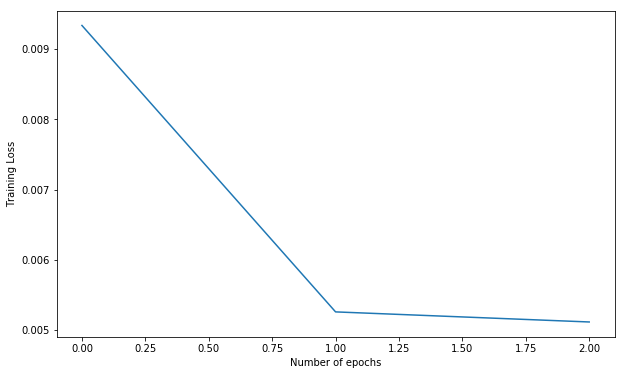

In [52]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('Number of epochs')

In [53]:
# Predict test dataset without confidence interval
predictions = model.predict(X_test_complete, batch_size=1000)


In [54]:
# invert scaling, differencing
pred = list()
X_vector = X_test_complete[:, -2:-1]
Y_vector = Y_test_complete[:, -1]
print(np.shape(X_vector))
print(np.shape(Y_vector))
print(np.shape(predictions[:, -1]))
print(np.shape(series[-2000:-1]))
preds = predictions[:, -1]
for i in range(len(X_test_complete)):
    X, y = X_vector[i], Y_vector[i]
    #print(X)
    # invert scaling
    yhat = invert_scale(scaler, X, preds[i])

    # invert differencing
    yhat = inverse_difference(series, yhat, len(X_test_complete)+1-i)
    # store forecast
    pred.append(yhat)
    expected = series[len(train) + i + 1]

(999, 1)
(999,)
(999,)
(1999,)


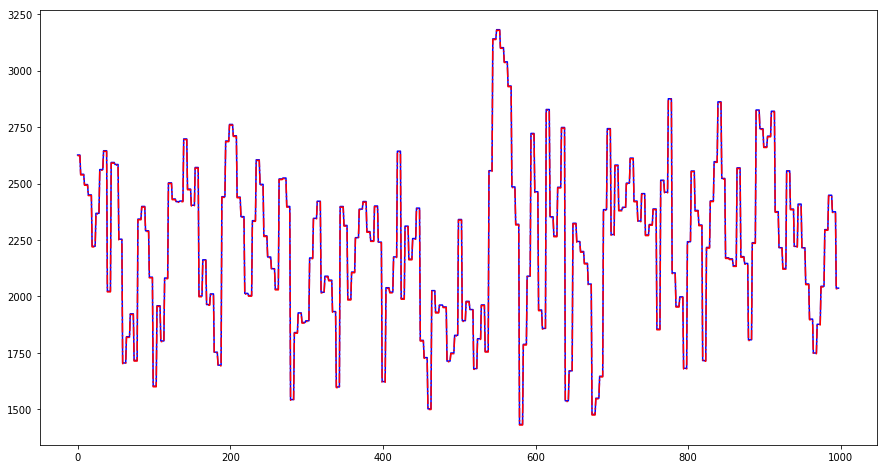

In [55]:
plt.figure(figsize=(15,8))
plt.plot(series[-2000+2*range_size+1:-1], 'b')
plt.plot(pred[1:], 'r-.')

In [56]:
# performance 
rmse = np.sqrt(mean_squared_error(series[-2000+2*range_size+1:-1], pred[1:]))
print('Test RMSE: %.3f' % rmse)

#model.save('SDN_model.h5')

Test RMSE: 2.963


***Prediction with confidence interval***  
https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras  
http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense  
https://www.reddit.com/r/deepfeec/comments/4bjwx7/plano_de_ataque_redes_neurais_bayesianas_resolvem/

In [21]:
# create tensorflow function to apply dropout during prediction
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [22]:
def predict_with_uncertainty(f, x, n_iter=200):
    """
    All below computation based on couple variables:
    l - prior length-scale, this captures our belief over the function frequency.
        A short length-scale l corresponds to high frequency data, and a long length-scale
        corresponds to low frequency data (choosen experimentally, I cannot confirm if this variable
        is good for this problem)
    N - number of training samples
    w_d - weight_decay (originally it was model.weight_decay but keras sequential model does not have this attribute
            and along with my understending it is just a regularization), in this situation we have Dropout
            regularization so this variable is also set experimentally, there should be further explenation
    """
    result = np.zeros((n_iter,) + x.shape)

    for iter in range(n_iter):
        result[iter] = f([np.asmatrix(x).reshape(2000,1), 1])[0][:,0]
        pred_1 = list()
        for i in range(len(result[iter])):
            # make one-step forecast
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            # invert scaling
            yhat = invert_scale(scaler, X, result[iter][i])
            # invert differencing
            yhat = inverse_difference(series, yhat, len(test_scaled)+1-i)
            # store forecast
            pred_1.append(yhat)
        result[iter] = pred_1

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    
    l = 1e2
    N = train_scaled.shape[0]
    w_d = 10
    tau = l**2 * (1 - 0.6) / (2 * N * w_d)
    uncertainty += tau**-1
    
    return prediction, uncertainty, result

In [23]:
# prediction part
p, u, r = predict_with_uncertainty(f,test_scaled[:,0])

InvalidArgumentError: Matrix size-incompatible: In[0]: [2000,1], In[1]: [500,16]
	 [[{{node dense_1/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_dense_1_input_0_0, dense_1/kernel/read)]]

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(series[-2000:-1], 'r.') # true values
plt.plot(p[1:], 'b') # predicted mean values
plt.fill_between(x = range(1999), y1 = p[1:]+u[1:], y2=p[1:]-u[1:]) # predicted uncertanity interval